# Part 4

For part 4 of the project, you will be using your MySQL database from part 3 to answer meaningful questions for your stakeholder. They want you to use your hypothesis testing and statistics knowledge to answer 3 questions about what makes a successful movie.

# Import

In [119]:
import pandas as pd
import numpy as np
import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import scipy


# Using Your API Credentials

In [120]:
# Load API Credentials

with open('/Users/Ernesto/.secret/tmdb_api.json') as f:
    login = json.load(f)

In [121]:
# display keys
login.keys()

dict_keys(['client-id', 'api-key'])

In [122]:
tmdb.API_KEY = login['api-key']

# Designate a folder

In [123]:
# create a new folder
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'df_2000_2001.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2011.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'final_tmdb_data_2013.csv.gz',
 'final_tmdb_data_2014.csv.gz',
 'final_tmdb_data_2015.csv.gz',
 'final_tmdb_data_2016.csv.gz',
 'final_tmdb_data_2017.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'final_tmdb_data_combined.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json']

# Defining Our Function

In [124]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [125]:
def get_movie_with_rating(movie_id):
    # get the movie object for the currend id
    movie = tmdb.Movies(movie_id)
    #save the .info .releases dictionaries
    info = movie.info()
    
    releases = movie.releases()
    # loop thrpoght countries in releases
    for c in releases['countries']:
        # if the country abbreviation == US
        if c['iso_3166_1'] =='US':
            # save a certificatiion key in info with the certification
            info['certification'] = c['certification']
    return info

# Requested a extraction of movies in 2000-2020

In [37]:
YEARS_TO_GET = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [38]:
## Define an errors list
errors = [ ]

In [39]:
# Open saved file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002,NaN,126,Drama


In [51]:
# OUTER and INNER loop

# Start of OUTER loop ( Iterate through years 2000 and 2001)

for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if JSON file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
            
    #Define/filter the IDs to call( From Basics dataset filter out movie ids for the year (2000 & 2001)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    # Start of INNER LOOP
    # Iterate through the list of Movies IDs and make the calls
        #Get index and movie id from list
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
            
    # Save your results as csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/10 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/3795 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4170 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4460 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4661 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4827 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/4962 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5168 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5546 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5664 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5758 [00:00<?, ?it/s]

In [52]:
# Print a message reporting back the number of movie ids that caused an error.
print(f"- Total errors: {len(errors)}")

- Total errors: 161792


In [126]:
YEARS_TO_GET = [2003, 2004, 2005, 2006, 2007, 2008, 2009]
## Define an errors list
errors = [ ]
# Open saved file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002,NaN,126,Drama


In [127]:
# OUTER and INNER loop

# Start of OUTER loop ( Iterate through years 2000 and 2001)

for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if JSON file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
            
    #Define/filter the IDs to call( From Basics dataset filter out movie ids for the year (2000 & 2001)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    # Start of INNER LOOP
    # Iterate through the list of Movies IDs and make the calls
        #Get index and movie id from list
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
            
    # Save your results as csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/7 [00:00<?, ?it/s]

Movies from 2003:   0%|          | 0/1642 [00:00<?, ?it/s]

Movies from 2004:   0%|          | 0/1855 [00:00<?, ?it/s]

Movies from 2005:   0%|          | 0/2146 [00:00<?, ?it/s]

Movies from 2006:   0%|          | 0/2363 [00:00<?, ?it/s]

Movies from 2007:   0%|          | 0/2509 [00:00<?, ?it/s]

Movies from 2008:   0%|          | 0/2853 [00:00<?, ?it/s]

Movies from 2009:   0%|          | 0/3485 [00:00<?, ?it/s]

In [133]:
YEARS_TO_GET = [2002, 2020]
## Define an errors list
errors = [ ]
# Open saved file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002,NaN,126,Drama


In [134]:
# OUTER and INNER loop

# Start of OUTER loop ( Iterate through years 2000 and 2001)

for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if JSON file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
            
    #Define/filter the IDs to call( From Basics dataset filter out movie ids for the year (2000 & 2001)
    #Saving new year as the current df
    df = basics.loc[ basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    # Start of INNER LOOP
    # Iterate through the list of Movies IDs and make the calls
        #Get index and movie id from list
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])
            
    # Save your results as csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2002:   0%|          | 0/281 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/4899 [00:00<?, ?it/s]

## Using Glob to Load Many Files

In [135]:
import glob
q = "Data/final_tmdb_data*.csv.gz"
tmdb_files = glob.glob(q)
# Showing 
tmdb_files



['Data\\final_tmdb_data_2000.csv.gz',
 'Data\\final_tmdb_data_2001.csv.gz',
 'Data\\final_tmdb_data_2002.csv.gz',
 'Data\\final_tmdb_data_2003.csv.gz',
 'Data\\final_tmdb_data_2004.csv.gz',
 'Data\\final_tmdb_data_2005.csv.gz',
 'Data\\final_tmdb_data_2006.csv.gz',
 'Data\\final_tmdb_data_2007.csv.gz',
 'Data\\final_tmdb_data_2008.csv.gz',
 'Data\\final_tmdb_data_2009.csv.gz',
 'Data\\final_tmdb_data_2010.csv.gz',
 'Data\\final_tmdb_data_2011.csv.gz',
 'Data\\final_tmdb_data_2012.csv.gz',
 'Data\\final_tmdb_data_2013.csv.gz',
 'Data\\final_tmdb_data_2014.csv.gz',
 'Data\\final_tmdb_data_2015.csv.gz',
 'Data\\final_tmdb_data_2016.csv.gz',
 'Data\\final_tmdb_data_2017.csv.gz',
 'Data\\final_tmdb_data_2018.csv.gz',
 'Data\\final_tmdb_data_2019.csv.gz',
 'Data\\final_tmdb_data_2020.csv.gz',
 'Data\\final_tmdb_data_combined.csv.gz']

## Combining Many Files

### For-Loop Way

In [136]:
## Loading all files as df and appending to a list
df_list = []
for file in tmdb_files:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined



,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2070.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,0.0,[],NaN,599083.0,ml,ഓട്ടം,"Set in Trivandrum, the story of Ottam unfolds ...",...,0.0,120.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Ottam,0.0,0.000,0.0,unknow
NaN,NaN,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.136,11.0,unknow
NaN,NaN,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,unknow
NaN,NaN,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,"Pep, a 13-year-old boy, is in love with a girl...",...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.714,7.0,unknow


# Save 

In [137]:
## Saving the final combined dataframe
final_fname ='Data/final_tmdb_data_combined.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)



In [54]:
df_combined = pd.read_csv(final_fname)
df_combined



,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.100,2070.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119812,NaN,NaN,NaN,0.0,[],NaN,599083.0,ml,ഓട്ടം,"Set in Trivandrum, the story of Ottam unfolds ...",...,0.0,120.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Ottam,0.0,0.000,0.0,unknow
119813,NaN,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.136,11.0,unknow
119814,NaN,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,unknow
119815,NaN,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,"Pep, a 13-year-old boy, is in love with a girl...",...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.714,7.0,unknow


### Explore data 

In [138]:
# check missing values
df_combined.isna().sum()

adult                    172336
backdrop_path             83961
belongs_to_collection    214743
budget                       64
genres                       64
homepage                 172884
id                           64
original_language            64
original_title               64
overview                   5223
popularity                   64
poster_path               19366
production_companies         64
production_countries         64
release_date               3346
revenue                      64
runtime                      64
spoken_languages             64
status                       64
tagline                  144431
title                        64
video                        64
vote_average                 64
vote_count                   64
certification            144621
dtype: int64

In [139]:
# check duplicates 
df_combined.duplicated().sum()

88991

In [140]:
# drop duplicates
df_combined = df_combined.drop_duplicates()
# check again 
df_combined.duplicated().sum()

0

# Hypothesis Testing

## Q1: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

In [141]:
# checking missing values in certification column
nan_certification = df_combined['certification'].isna().sum()
print(f'there are {nan_certification} movies with missing certification')

there are 82834 movies with missing certification


In [142]:
# replace nan per unknow
df_combined['certification'] = df_combined['certification'].fillna('unknow')

C:\Users\Ernesto\AppData\Local\Temp\ipykernel_10760\3013348432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['certification'] = df_combined['certification'].fillna('unknow')


In [143]:
# check missing values again
nan_certification = df_combined['certification'].isna().sum()
print(f'there are {nan_certification} movies with missing certification')

there are 0 movies with missing certification


In [144]:
df_combined['certification'].value_counts()

unknow                             113697
R                                   11305
NR                                   6118
PG-13                                6029
PG                                   2662
G                                     811
NC-17                                 293
Unrated                                10
-                                       2
UR                                      2
Not Rated                               2
ScreamFest Horror Film Festival         2
R                                       2
PG-13                                   2
10                                      2
Name: certification, dtype: int64

In [145]:
# there are 2 R and PG-13, let's check what is the problem 
df_combined['certification'].unique()

array(['unknow', 'PG', 'R', 'G', 'NR', 'PG-13', 'NC-17', 'Unrated', '-',
       'UR', 'Not Rated', 'ScreamFest Horror Film Festival', 'R ',
       'PG-13 ', '10'], dtype=object)

In [146]:
# replace - to 'NR' and remove white space
## fix certification col
repl_cert = {'PG-13 ':'PG-13', 'R ':'R', 'UR':'NR', 'Not Rated':'NR', 'Unrated':'NR', '-':'NR', '10':'unknow',
             'ScreamFest Horror Film Festival':'NR'}

df_combined['certification'] = df_combined['certification'].replace(repl_cert)
df_combined['certification'].value_counts(dropna=False)

C:\Users\Ernesto\AppData\Local\Temp\ipykernel_10760\1070025149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['certification'] = df_combined['certification'].replace(repl_cert)


unknow    113699
R          11307
NR          6136
PG-13       6031
PG          2662
G            811
NC-17        293
Name: certification, dtype: int64

In [147]:
# checking missing values in revenue column
nan_revenue = df_combined['revenue'].isna().sum()
print(f'there are {nan_revenue} movies with missing revenue')

there are 1 movies with missing revenue


In [148]:
# drop row with missing values 
df_combined = df_combined.dropna(subset=['revenue'])

In [149]:
# checking missing values in revenue column
nan_revenue = df_combined['revenue'].isna().sum()
print(f'there are {nan_revenue} movies with missing revenue')

there are 0 movies with missing revenue


In [150]:
df_combined['revenue'].value_counts()

0.0           124560
10000.0           82
2000000.0         44
100000.0          43
1000000.0         34
               ...  
23833131.0         1
45867333.0         1
1347988.0          1
429189.0           1
236880.0           1
Name: revenue, Length: 7081, dtype: int64

### 1. State the Hypothesis & Null Hypothesis

 H0 (Null Hypothesis): no difference in revenue amount between all MPAA rating.
 
 
 HA(Alternative Hypothesis): there is a significant difference in revenue amount between ratings.

### 2. Determine the correct test to perform.

Type of Data? numeric

How many groups/samples?  more than two

Therefore, which test is appropriate? ANOVA

In [151]:
rating_names = df_combined['certification'].unique()
rating_names

array(['unknow', 'PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'], dtype=object)

### 3. Testing Assumptions

In [152]:
## Create groups dictionary. There are only 4 groups
groups = {}
## Loop through all unique categories
for i in df_combined['certification'].unique():
    ## Get series for group and rename
    data = df_combined.loc[df_combined['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['unknow', 'PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'])

#### No significant outliers - outliers ( z > 3)

In [153]:
groups_clean = {}
## Loop through groups dict
for sector_name, grp_data in groups.items():
    
    ## determine if there are any outliers
    idx_outliers = np.abs(stats.zscore(grp_data)) > 3
    ## print a statement about how many outliers for which group name
    print(f'there were {idx_outliers.sum()} outliers in {sector_name}')

    ## Remove the outiers from data and overwrite the sector data in the dict
    grp_data_cln = grp_data[idx_outliers == False]
    groups_clean[sector_name] = grp_data_cln
    

there were 494 outliers in unknow
there were 72 outliers in PG
there were 226 outliers in R
there were 20 outliers in G
there were 56 outliers in NR
there were 158 outliers in PG-13
there were 4 outliers in NC-17


#### Normality

In [154]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups_clean.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
unknow,113204.0,0.000000e+00,189987.865911
PG,2590.0,0.000000e+00,1563.737493
R,11081.0,0.000000e+00,8227.920633
G,791.0,4.979026e-131,600.066826
NR,6080.0,0.000000e+00,9903.356963
PG-13,5873.0,0.000000e+00,3793.286925
NC-17,289.0,1.531707e-74,339.929829


In [155]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
unknow,113204.0,0.000000e+00,189987.865911,True
PG,2590.0,0.000000e+00,1563.737493,True
R,11081.0,0.000000e+00,8227.920633,True
G,791.0,4.979026e-131,600.066826,True
NR,6080.0,0.000000e+00,9903.356963,True
PG-13,5873.0,0.000000e+00,3793.286925,True
NC-17,289.0,1.531707e-74,339.929829,True


Our p-values for all group are below 0.05 which means our data is NOT normally distributed. However, our our sample size is large enough (n>20) to proceed without satisfying this test.

#### Equal Variance

In [156]:
# with the * operator 
stats.levene(*groups_clean.values())

LeveneResult(statistic=4400.757908014222, pvalue=0.0)

p<0.05 fail the assumption of equal variance we need select a non-parametric equivalent test - Kruskal-Wallis test

### 4 - Final Hypothesis Test

In [157]:
## Run final test and get p-value
stats.kruskal(*groups_clean.values())

KruskalResult(statistic=28719.975655133385, pvalue=0.0)

### 5 - Interpret your p-value and reject or fail to reject your null hypothesis

p < 0.05 - reject null hypothesis and support the alternate hypothesis there is a significant difference in revenue amount between ratings.

### 6 - Show a supporting visualization that helps display the result

#### Average

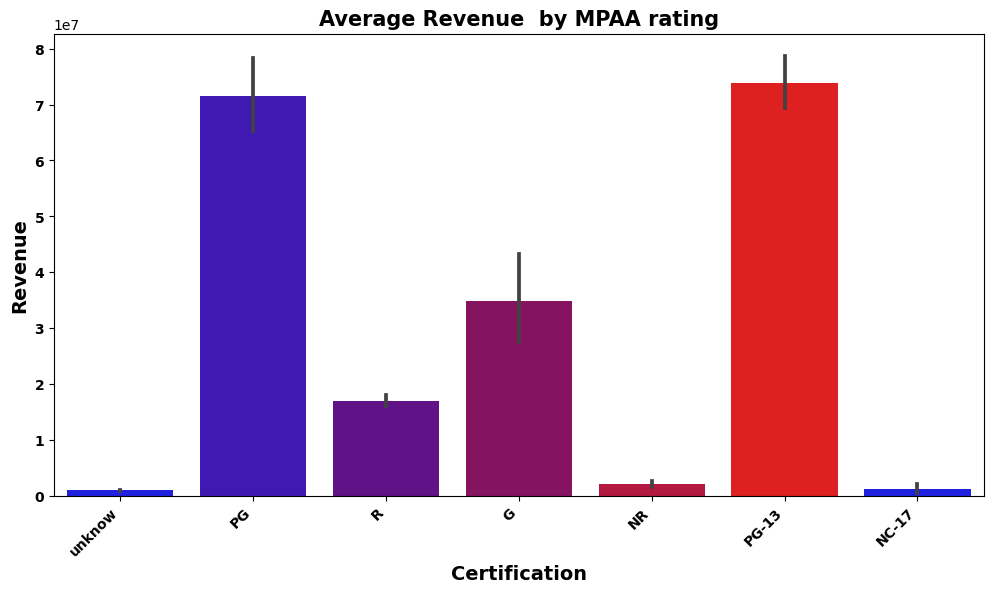

In [158]:
fig, ax = plt.subplots(figsize=(12,6))
palette = sns.blend_palette(['blue', 'red'])
ax= sns.barplot(data = df_combined, x='certification', y = 'revenue', palette= palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha= 'right')
plt.title('Average Revenue  by MPAA rating', fontsize=15, weight='bold')
plt.xlabel('Certification', fontsize = 14, weight='bold')
plt.ylabel('Revenue', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');
plt.show()

PG and PG3 were the rating with higher average revenue, NR, NC-17 and Unknow were the rating with lower average revenue.

#### Total

In [159]:
top = df_combined.groupby('certification')['revenue'].sum()
df_top = pd.DataFrame(top).sort_values('revenue', ascending = False)
df_top
     

,revenue
certification,
PG-13,4.449535e+11
R,1.916423e+11
PG,1.904844e+11
unknow,1.073883e+11
G,2.824850e+10
NR,1.234261e+10
NC-17,3.522922e+08


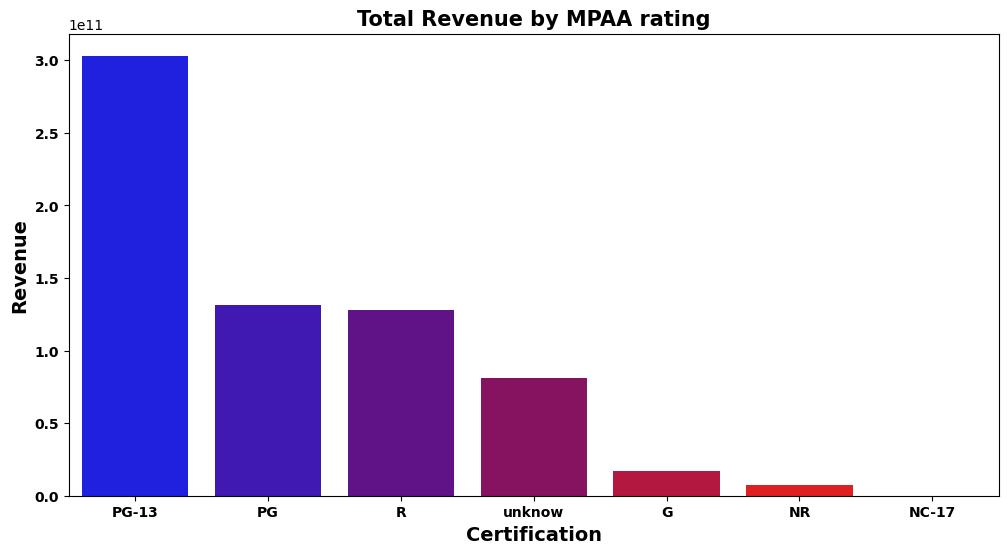

In [114]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=df_top, y='revenue', x=df_top.index, palette=palette); 

plt.title('Total Revenue by MPAA rating', fontsize = 15, weight='bold')
plt.xlabel('Certification', fontsize = 14, weight='bold')
plt.ylabel('Revenue', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');

plt.show;


PG13 was ratting with the higher total revenue amount. G, NR and NC-17 were the  ratting with lower total revenue.  

### Post-Hoc Multiple Comparison Test

In [160]:
## slice a test sector
temp = None

In [161]:
## make a list for saving the dataframes to
tukeys_dfs = []

## Loop through groups dict's items
for sector, temp in groups_clean.items():
    
    ## make a temp_df with the data and the sector name
    temp_df = pd.DataFrame({'revenue' : temp, 'certification': sector})
    ## append to tukeys_dfs
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

,revenue,certification
tt0113026,0.0,unknow
tt0113092,0.0,unknow
tt0116391,0.0,unknow
tt0119806,0.0,unknow
tt0120202,0.0,unknow
...,...,...
0.0,100000.0,NC-17
1.0,0.0,NC-17
1.0,0.0,NC-17
0.0,0.0,NC-17


In [162]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## save the values as kg_lost and the labels to the Diet
values = tukeys_data['revenue']
labels = tukeys_data['certification']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-19116177.8539,0.0,-24554766.6296,-13677589.0782,True
G,NR,-19099176.5426,0.0,-22089935.7629,-16108417.3223,True
G,PG,28507410.6153,0.0,25293039.8537,31721781.377,True
G,PG-13,28977970.7635,0.0,25981150.0663,31974791.4608,True
G,R,-9287697.3247,0.0,-12199726.5697,-6375668.0797,True
G,unknow,-19306386.3483,0.0,-22129544.9748,-16483227.7218,True
NC-17,NR,17001.3113,1.0,-4746720.8175,4780723.4401,False
NC-17,PG,47623588.4692,0.0,42716390.9798,52530785.9586,True
NC-17,PG-13,48094148.6174,0.0,43326618.6387,52861678.5962,True
NC-17,R,9828480.5292,0.0,5113788.3727,14543172.6857,True


There is no difference (p>0.05) between: 

                               NC-17 and NR
                               
                               NC-17 and unknow
                               
                               NR and unknow
                               
                               PG AND PG3

These groups have similar x values in tukey plot below: 

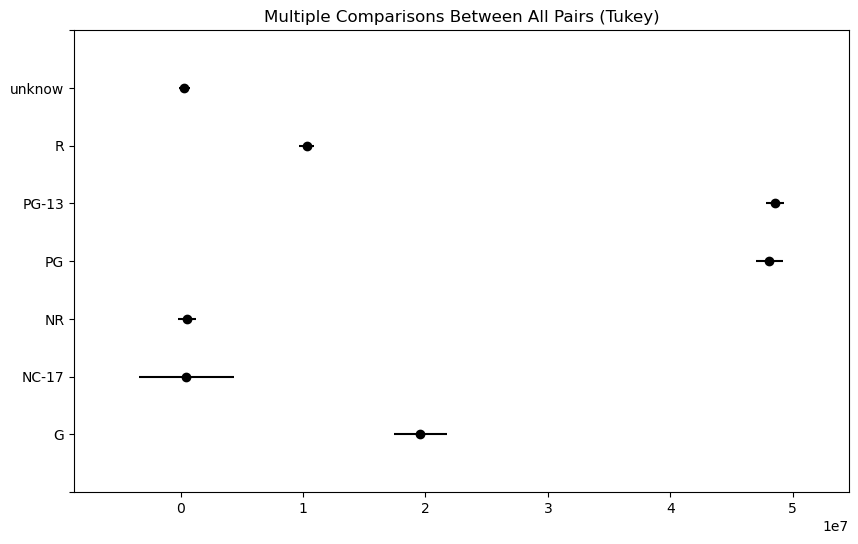

In [163]:
## also can use built-in plot tukeys_reuslts.plot_simultaneous
tukeys_results.plot_simultaneous(); 

# Q2 - Do some movie genres earn more revenue than others?

In [226]:
df_combined['genres']

tt0113026    [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
tt0113092             [{'id': 878, 'name': 'Science Fiction'}]
tt0116391    [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...
tt0118694    [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...
tt0118852                        [{'id': 18, 'name': 'Drama'}]
                                   ...                        
NaN                                                         []
NaN          [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
NaN                              [{'id': 18, 'name': 'Drama'}]
NaN          [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...
NaN                                                         []
Name: genres, Length: 140938, dtype: object

In [227]:
## Function to get just the genre names as a list 

def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [228]:
## Use our function and exploding the new column
#get_genre_name(df.loc[3,'genres'])

# use get_genre_name and convert all the genere name in list
df_combined['genres_list'] = df_combined['genres'].apply(get_genre_name)
df_explode = df_combined.explode('genres_list')
df_explode

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,unknow,Comedy
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,unknow,Music
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,unknow,Romance
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,2.566,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 925, 'logo_path': '/dIb9hjXNOkgxu4kBWd...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,unknow,Science Fiction
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",0.840,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,unknow,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,1.374,/cNWfJlveyMEbiORrKmFKZZRDx75.jpg,"[{'id': 113177, 'logo_path': None, 'name': 'Ne...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2019-09-27,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.136,11.0,unknow,Drama
NaN,NaN,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,0.635,/fqIWD97MAjgrj8mB2M78kxeSSnk.jpg,[],[],2019-10-23,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,unknow,Drama
NaN,NaN,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,"Pep, a 13-year-old boy, is in love with a girl...",8.002,/ulCLv5kRiC8JnxdRBczDzx0NjSr.jpg,"[{'id': 20786, 'logo_path': None, 'name': ""Mas...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",2019-07-12,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.714,7.0,unknow,Drama
NaN,NaN,/tjHUeULyw

In [229]:
# check missing values 
df_explode['genres_list'].isna().sum()

14143

In [230]:
# replace nan per unknow
df_explode['genres_list'] = df_explode['genres_list'].fillna('Unknow')

In [231]:
# check missing values 
df_explode['genres_list'].isna().sum()

0

In [232]:
## save unique genres

unique_genres = df_explode['genres_list'].dropna().unique()
unique_genres

array(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action',
       'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller',
       'History', 'Family', 'Mystery', 'Western', 'Unknow', 'War',
       'TV Movie', 'Documentary'], dtype=object)

In [233]:
# checking missing values in revenue column
nan_revenue = df_explode['revenue'].isna().sum()
print(f'there are {nan_revenue} movies with missing revenue')

there are 0 movies with missing revenue


In [234]:
# checking duplicates 
df_explode.duplicated().sum()

53716

In [235]:
# drop duplicates 
df_explode = df_explode.drop_duplicates()
df_explode.duplicated().sum()

0

### 1. State the Hypothesis & Null Hypothesis

 H0 (Null Hypothesis): no difference in revenue amount between all genres.
 
 
 HA(Alternative Hypothesis): there is a significant difference in revenue amount between genres.

### 2. Determine the correct test to perform.

Type of Data? numeric

How many groups/samples?  more than two

Therefore, which test is appropriate? ANOVA

### 3. Testing Assumptions

In [236]:
## Create groups dictionary. There are only 4 groups
groups = {}
## Loop through all unique categories
for i in df_explode['genres_list'].unique():
    ## Get series for group and rename
    data = df_explode.loc[df_explode['genres_list']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action', 'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller', 'History', 'Family', 'Mystery', 'Western', 'Unknow', 'War', 'TV Movie', 'Documentary'])

#### No significant outliers - outliers ( z > 3)

In [237]:
groups_clean = {}
## Loop through groups dict
for sector_name, grp_data in groups.items():
    
    ## determine if there are any outliers
    idx_outliers = np.abs(stats.zscore(grp_data)) > 3
    ## print a statement about how many outliers for which group name
    print(f'there were {idx_outliers.sum()} outliers in {sector_name}')

    ## Remove the outiers from data and overwrite the sector data in the dict
    grp_data_cln = grp_data[idx_outliers == False]
    groups_clean[sector_name] = grp_data_cln

there were 452 outliers in Comedy
there were 31 outliers in Music
there were 229 outliers in Romance
there were 115 outliers in Science Fiction
there were 611 outliers in Drama
there were 260 outliers in Action
there were 119 outliers in Crime
there were 184 outliers in Adventure
there were 115 outliers in Animation
there were 133 outliers in Fantasy
there were 264 outliers in Horror
there were 276 outliers in Thriller
there were 59 outliers in History
there were 142 outliers in Family
there were 125 outliers in Mystery
there were 12 outliers in Western
there were 5 outliers in Unknow
there were 29 outliers in War
there were 2 outliers in TV Movie
there were 4 outliers in Documentary


#### Normality

 Our our sample size is large enough (n>20) to proceed without satisfying this test.

#### Equal Variance

In [238]:
# with the * operator 
stats.levene(*groups_clean.values())

LeveneResult(statistic=609.9069586158835, pvalue=0.0)

p<0.05 fail the assumption of equal variance we need select a non-parametric equivalent test - Kruskal-Wallis test

### 4 - Final Hypothesis Test

In [240]:
## Run final test and get p-value
stats.kruskal(*groups_clean.values())

KruskalResult(statistic=7133.177100216466, pvalue=0.0)

### 5 - Interpret your p-value and reject or fail to reject your null hypothesis

p < 0.05 - reject null hypothesis and support the alternate hypothesis there is a significant difference in revenue amount between genres.

### 6 - Show a supporting visualization that helps display the result

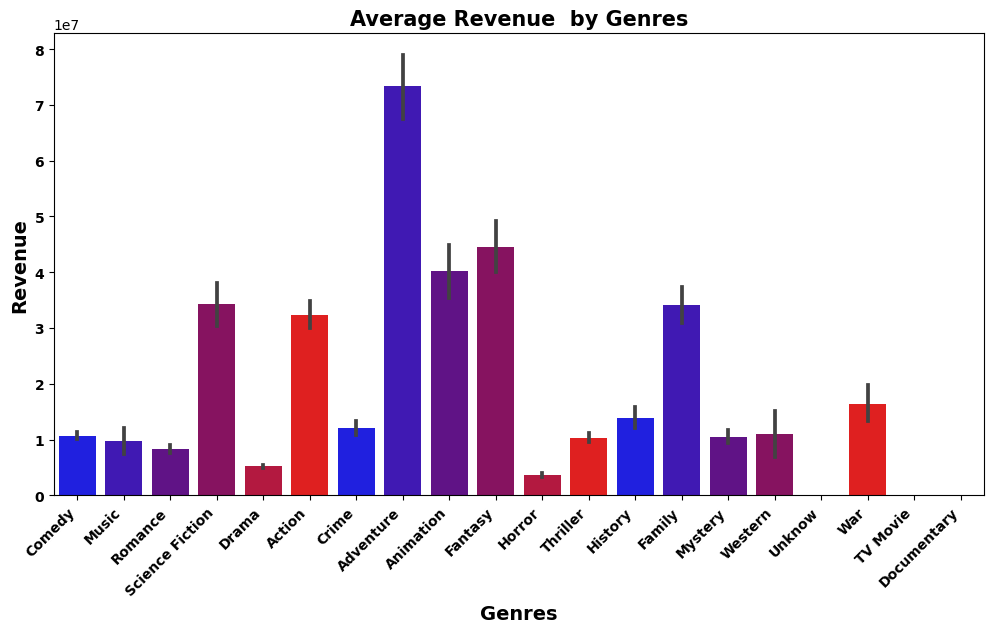

In [259]:
fig, ax = plt.subplots(figsize=(12,6))
palette = sns.blend_palette(['blue', 'red'])
ax= sns.barplot(data = df_explode, x='genres_list', y = 'revenue', palette= palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha= 'right')
plt.title('Average Revenue  by Genres', fontsize=15, weight='bold')
plt.xlabel('Genres', fontsize = 14, weight='bold')
plt.ylabel('Revenue', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');
plt.show()

Adventure was the genre with higher average revenue. Documentary, TV movie horror and drama were the genres with lower average revenue. 

In [242]:
top = df_explode.groupby('genres_list')['revenue'].sum()
df_top = pd.DataFrame(top).sort_values('revenue', ascending = False)
df_top
     

,revenue
genres_list,
Adventure,4.309059e+11
Action,4.224323e+11
Comedy,3.176190e+11
Drama,2.720132e+11
Fantasy,2.229575e+11
Thriller,2.038668e+11
Family,2.019079e+11
Science Fiction,2.018610e+11
Animation,1.477033e+11


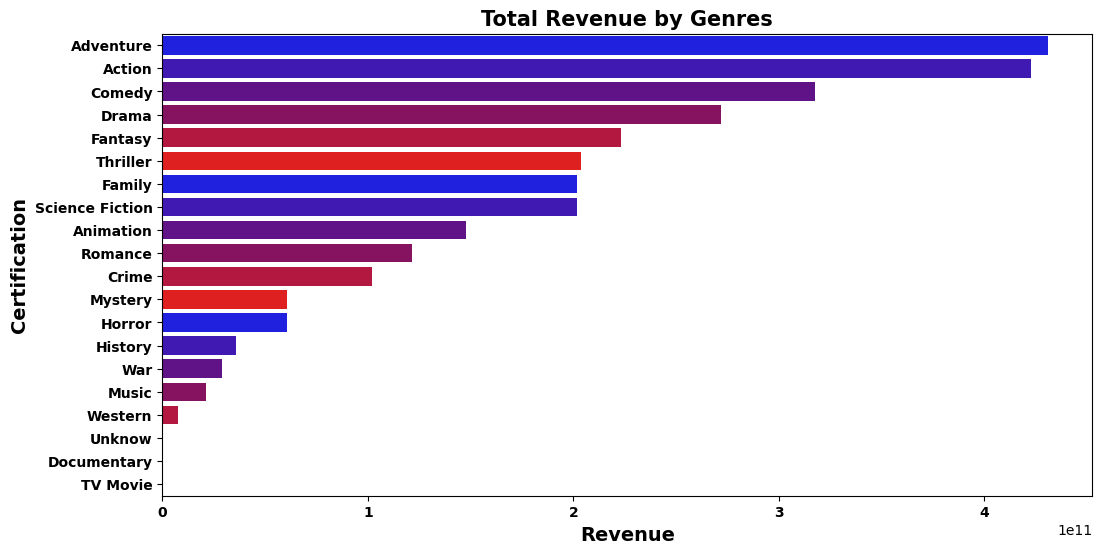

In [243]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=df_top, x='revenue', y=df_top.index, palette=palette); 

plt.title('Total Revenue by Genres', fontsize = 15, weight='bold')
plt.ylabel('Certification', fontsize = 14, weight='bold')
plt.xlabel('Revenue', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');

plt.show;


Adventure and Action were the genres with higher total revenue. TV Movie, Documentary and unknow were the genres with lower total revenue. 

### Post-Hoc Multiple Comparison Test

In [244]:
## slice a test sector
temp = None
## make a list for saving the dataframes to
tukeys_dfs = []

## Loop through groups dict's items
for sector, temp in groups_clean.items():
    
    ## make a temp_df with the data and the sector name
    temp_df = pd.DataFrame({'revenue' : temp, 'genres_list': sector})
    ## append to tukeys_dfs
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

,revenue,genres_list
tt0113026,0.0,Comedy
tt0119495,0.0,Comedy
tt0119806,0.0,Comedy
tt0120202,0.0,Comedy
tt0120263,80334.0,Comedy
...,...,...
0.0,0.0,Documentary
0.0,0.0,Documentary
0.0,0.0,Documentary
0.0,0.0,Documentary


In [245]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## save the values as kg_lost and the labels to the Diet
values = tukeys_data['revenue']
labels = tukeys_data['genres_list']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,25802635.9814,0.0,23882863.9016,27722408.0612,True
Action,Animation,2064033.8554,0.1386,-219648.474,4347716.1848,False
Action,Comedy,-11401201.9822,0.0,-12678513.6562,-10123890.3082,True
Action,Crime,-9578988.9591,0.0,-11279143.9102,-7878834.0081,True
Action,Documentary,-16208639.3284,0.0,-20752379.4483,-11664899.2084,True
Action,Drama,-14127688.7393,0.0,-15316527.6509,-12938849.8277,True
Action,Family,685481.857,0.9994,-1225172.6054,2596136.3195,False
Action,Fantasy,5313029.6279,0.0,3283758.268,7342300.9879,True
Action,History,-8613763.118,0.0,-11232186.7295,-5995339.5064,True
Action,Horror,-15127284.4063,0.0,-16554377.49,-13700191.3226,True


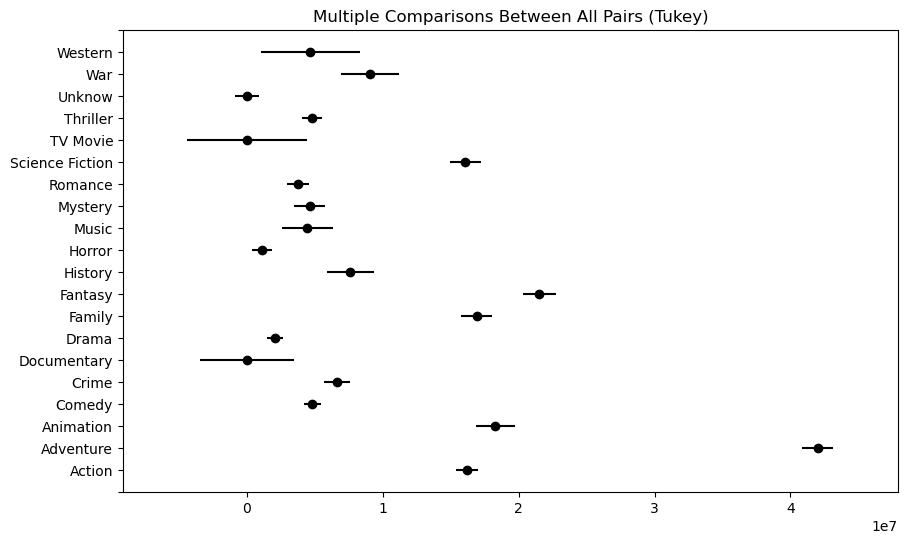

In [246]:
## also can use built-in plot tukeys_reuslts.plot_simultaneous
tukeys_results.plot_simultaneous(); 

Adventure was the genres with with more different revenue. 

# Q3 - Are some genres higher popularity than others?

In [247]:
pd.set_option('display.max_columns',100)
df_explode.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,unknow,Comedy
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,unknow,Music
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.291,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/1SEj4nyG3JPBSKBbFht...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,unknow,Romance
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,2.566,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 925, 'logo_path': '/dIb9hjXNOkgxu4kBWd...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,unknow,Science Fiction
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",0.840,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,unknow,Drama


In [248]:
# check missing values 
df_explode['genres_list'].isna().sum()

0

In [249]:
# check missing values 
df_explode['popularity'].isna().sum()

0

### 1. State the Hypothesis & Null Hypothesis

H0 (Null Hypothesis): no difference in popularity between all genres.

HA(Alternative Hypothesis): there is a significant difference in popularity  between genres.


### 2. Determine the correct test to perform.

Type of Data? numeric

How many groups/samples?  more than two

Therefore, which test is appropriate? ANOVA

### 3. Testing Assumptions

In [254]:
## Create groups dictionary. There are only 4 groups
groups = {}
## Loop through all unique categories
for i in df_explode['genres_list'].unique():
    ## Get series for group and rename
    data = df_explode.loc[df_explode['genres_list']==i,'popularity'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action', 'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller', 'History', 'Family', 'Mystery', 'Western', 'Unknow', 'War', 'TV Movie', 'Documentary'])

#### No significant outliers - outliers ( z > 3



In [255]:
groups_clean = {}
## Loop through groups dict
for sector_name, grp_data in groups.items():
    
    ## determine if there are any outliers
    idx_outliers = np.abs(stats.zscore(grp_data)) > 3
    ## print a statement about how many outliers for which group name
    print(f'there were {idx_outliers.sum()} outliers in {sector_name}')

    ## Remove the outiers from data and overwrite the sector data in the dict
    grp_data_cln = grp_data[idx_outliers == False]
    groups_clean[sector_name] = grp_data_cln

there were 427 outliers in Comedy
there were 36 outliers in Music
there were 211 outliers in Romance
there were 30 outliers in Science Fiction
there were 863 outliers in Drama
there were 107 outliers in Action
there were 177 outliers in Crime
there were 15 outliers in Adventure
there were 56 outliers in Animation
there were 13 outliers in Fantasy
there were 338 outliers in Horror
there were 350 outliers in Thriller
there were 40 outliers in History
there were 21 outliers in Family
there were 117 outliers in Mystery
there were 2 outliers in Western
there were 138 outliers in Unknow
there were 33 outliers in War
there were 11 outliers in TV Movie
there were 17 outliers in Documentary


#### Normality

 Our sample size is large enough (n>20) to proceed without satisfying this test.

#### Equal Variance

In [256]:
# with the * operator 
stats.levene(*groups_clean.values())

LeveneResult(statistic=1030.8859074673142, pvalue=0.0)

p<0.05 fail the assumption of equal variance we need select a non-parametric equivalent test - Kruskal-Wallis test

### 4 - Final Hypothesis Test

In [257]:
## Run final test and get p-value
stats.kruskal(*groups_clean.values())

KruskalResult(statistic=25360.27351786209, pvalue=0.0)

### 5 - Interpret your p-value and reject or fail to reject your null hypothesis

p < 0.05 - reject null hypothesis and support the alternate hypothesis there is a significant difference in popularity between genres.

### 6 - Show a supporting visualization that helps display the result

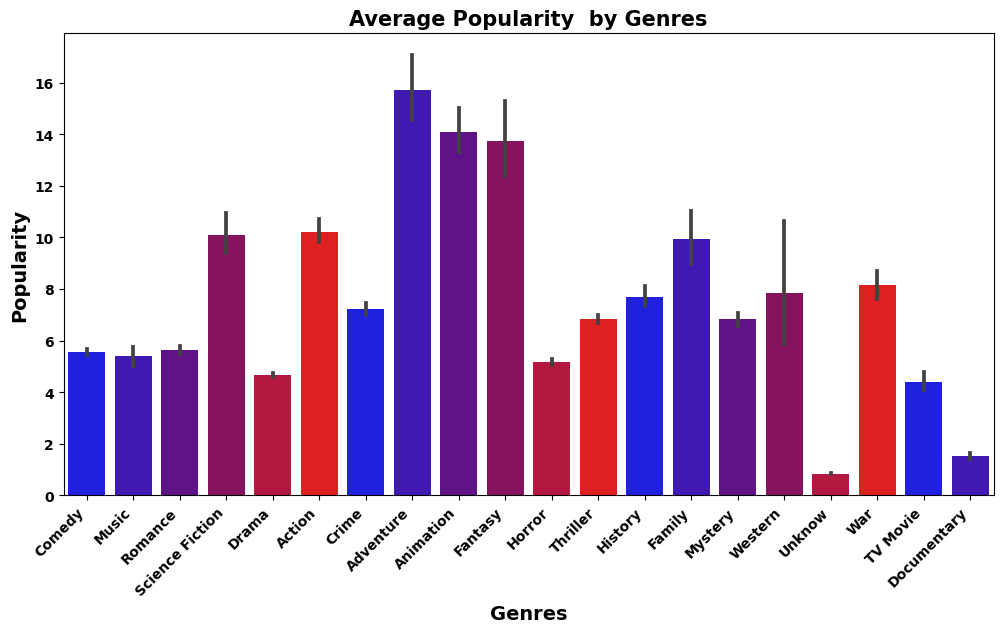

In [258]:
fig, ax = plt.subplots(figsize=(12,6))
palette = sns.blend_palette(['blue', 'red'])
ax= sns.barplot(data = df_explode, x='genres_list', y = 'popularity', palette= palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha= 'right')
plt.title('Average Popularity  by Genres', fontsize=15, weight='bold')
plt.xlabel('Genres', fontsize = 14, weight='bold')
plt.ylabel('Popularity', fontsize = 14, weight='bold');
plt.xticks(fontsize = 10, weight='bold')
plt.yticks(fontsize = 10, weight='bold');
plt.show()

Adventure, Animation and Fantasy were genres with higher popularity. Documentary was the genre with lower popularity. 

Let's do Post-Hoc Multiple Comparison Test to see if these difference are significant 

### Post-Hoc Multiple Comparison Test

In [264]:
## slice a test sector
temp = None
## make a list for saving the dataframes to
tukeys_dfs = []

## Loop through groups dict's items
for sector, temp in groups_clean.items():
    
    ## make a temp_df with the data and the sector name
    temp_df = pd.DataFrame({'popularity' : temp, 'genres_list': sector})
    ## append to tukeys_dfs
    tukeys_dfs.append(temp_df)
    
## concatenate them into 1 dataframe
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

,popularity,genres_list
tt0113026,3.291,Comedy
tt0119495,1.091,Comedy
tt0119806,0.600,Comedy
tt0120202,13.040,Comedy
tt0120263,9.293,Comedy
...,...,...
0.0,1.176,Documentary
0.0,0.852,Documentary
0.0,0.600,Documentary
0.0,0.677,Documentary


In [265]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## save the values as kg_lost and the labels to the Diet
values = tukeys_data['popularity']
labels = tukeys_data['genres_list']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,5.0243,0.0,4.5457,5.5029,True
Action,Animation,3.0057,0.0,2.434,3.5774,True
Action,Comedy,-4.4226,0.0,-4.7435,-4.1018,True
Action,Crime,-2.9429,0.0,-3.3718,-2.5141,True
Action,Documentary,-7.7243,0.0,-8.8797,-6.5688,True
Action,Drama,-5.1219,0.0,-5.4205,-4.8233,True
Action,Family,-0.4346,0.1309,-0.9123,0.0431,False
Action,Fantasy,2.9318,0.0,2.4252,3.4384,True
Action,History,-2.1902,0.0,-2.8481,-1.5324,True
Action,Horror,-4.8274,0.0,-5.1866,-4.4682,True


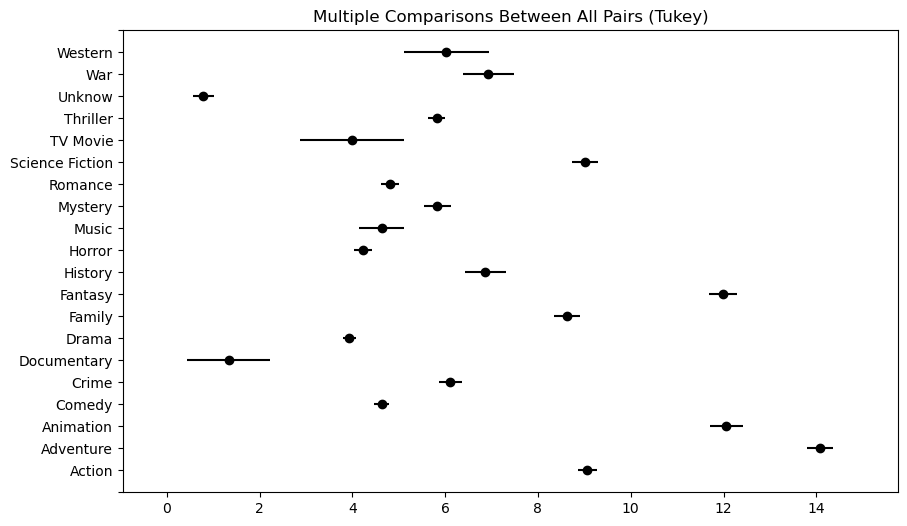

In [266]:
## also can use built-in plot tukeys_reuslts.plot_simultaneous
tukeys_results.plot_simultaneous();

Genres with similar x value  = there is no difference.